In [1]:
import logging
import os
import sys
from hydra import initialize, compose
from omegaconf import OmegaConf

# Jupyter 노트북에서 상위 디렉토리를 Python 경로에 추가
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from src.data.MNIST_data import MNISTDataModule
from src.models.auto_encoder import AutoEncoder
from src.utils.visualize_autoencoder import (
    visualize_latent_space,
    generate_from_latent,
    generate_latent_grid,
    visualize_sample_data,
)

# Hydra 설정 로드
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="autoencoder")

# 로깅 설정
logging.basicConfig(
    level=getattr(logging, cfg.logging.level),
    format=cfg.logging.format,
    datefmt=cfg.logging.datefmt,
    force=True,
)

log = logging.getLogger(__name__)
log.info("=" * 80)
log.info("Configuration:")
log.info(OmegaConf.to_yaml(cfg))
log.info("=" * 80)

15:31:23|INFO|818045884.py:34| ================================================================================
15:31:23|INFO|818045884.py:35| Configuration:
15:31:23|INFO|818045884.py:36| logging:
  save_dir: ./saved/tensorboard_logs
  name: mnist-autoencoder
  checkpoint_dir: ./saved/checkpoints
  default_root_dir: ./saved/logs
  save_top_k: 1
  format: '%(asctime)s|%(levelname)s|%(filename)s:%(lineno)d| %(message)s'
  datefmt: '%H:%M:%S'
  level: DEBUG
data:
  data_dir: ~/data/
  batch_size: 32
  target_labels:
  - 0
  - 1
  - 3
  - 8
model:
  latent_dim: 2
  hidden_dim: 256
training:
  max_epochs: 2
  lr: 0.001
  weight_decay: 0.1
  T_max: 100
trainer:
  devices: auto
  log_every_n_steps: 5
  val_check_interval: 1.0
  enable_progress_bar: true
  enable_model_summary: true
seed: 42
float32_matmul_precision: medium

15:31:23|INFO|818045884.py:37| ================================================================================


In [2]:
# 데이터 로드
mnist = MNISTDataModule(
    data_dir=cfg.data.data_dir,
    batch_size=cfg.data.batch_size,
    target_labels=cfg.data.target_labels,
)
mnist.setup("fit")

log.info(f"Train dataset size: {len(mnist.train_dataloader().dataset)}")
log.info(f"Val dataset size: {len(mnist.val_dataloader().dataset)}")
log.info(f"Test dataset size: {len(mnist.test_dataloader().dataset)}")

15:31:23|INFO|MNIST_data.py:37| 필터링: [0, 1, 3, 8]
15:31:32|INFO|2249619518.py:9| Train dataset size: 22182
15:31:32|INFO|2249619518.py:10| Val dataset size: 2465
15:31:32|INFO|2249619518.py:11| Test dataset size: 4099


In [3]:
# 체크포인트에서 모델 로드
import glob

checkpoint_dir = os.path.join('..', cfg.logging.checkpoint_dir)
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))

if not checkpoint_files:
    log.error(f"No checkpoint files found in {checkpoint_dir}")
    log.info("Please train the model first by running train_autoencoder.py")
else:
    # 가장 최근 체크포인트 선택
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    log.info(f"Loading checkpoint: {latest_checkpoint}")
    
    autoencoder = AutoEncoder.load_from_checkpoint(latest_checkpoint)
    autoencoder.eval()
    log.info("Model loaded successfully")

15:31:32|INFO|2048806456.py:13| Loading checkpoint: .././saved/checkpoints/autoencoder-epoch=02-val_loss=0.04.ckpt
15:31:32|DEBUG|local.py:379| open file: /data/ephemeral/home/juik/lightning/notebooks/.././saved/checkpoints/autoencoder-epoch=02-val_loss=0.04.ckpt
15:31:32|INFO|2048806456.py:17| Model loaded successfully


# 1. 샘플 데이터 시각화
원본 이미지와 재구성된 이미지를 비교합니다.

15:31:32|DEBUG|pyplot.py:496| Loaded backend module://matplotlib_inline.backend_inline version unknown.
15:31:32|DEBUG|pyplot.py:496| Loaded backend module://matplotlib_inline.backend_inline version unknown.
15:31:32|DEBUG|font_manager.py:1471| findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
15:31:32|DEBUG|font_manager.py:1483| findfont: score(FontEntry(fname='/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
15:31:32|DEBUG|font_manager.py:1483| findfont: score(FontEntry(fname='/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
15:31:32|DEBUG|font_manager.py:1483| findfont: score(FontEntry(fna

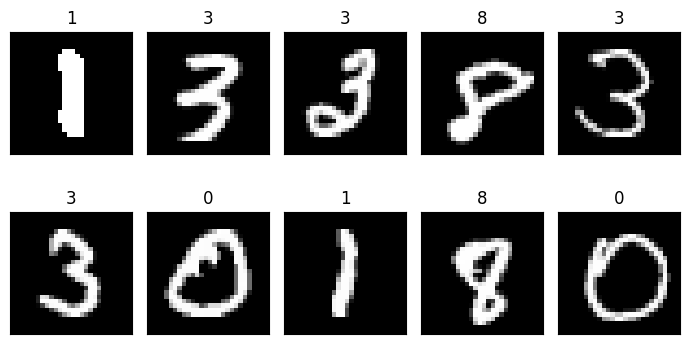

In [4]:
# 테스트 데이터로 샘플 시각화
data_loader = mnist.train_dataloader()
visualize_sample_data(data_loader)

# 2. Latent Space 시각화
2D latent space에 테스트 데이터를 투영하여 클러스터링을 확인합니다.

15:31:32|INFO|visualize_autoencoder.py:67| Model is on device: cuda:0
15:31:33|INFO|visualize_autoencoder.py:96| Latent coordinates shape: (4099, 2)
15:31:33|INFO|visualize_autoencoder.py:97| Labels shape: (4099,)
15:31:33|DEBUG|font_manager.py:1471| findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=14.0.
15:31:33|DEBUG|font_manager.py:1483| findfont: score(FontEntry(fname='/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
15:31:33|DEBUG|font_manager.py:1483| findfont: score(FontEntry(fname='/data/ephemeral/home/juik/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
15:31:33|DEBUG|font_manager.py:1483| findfont: score(FontEnt

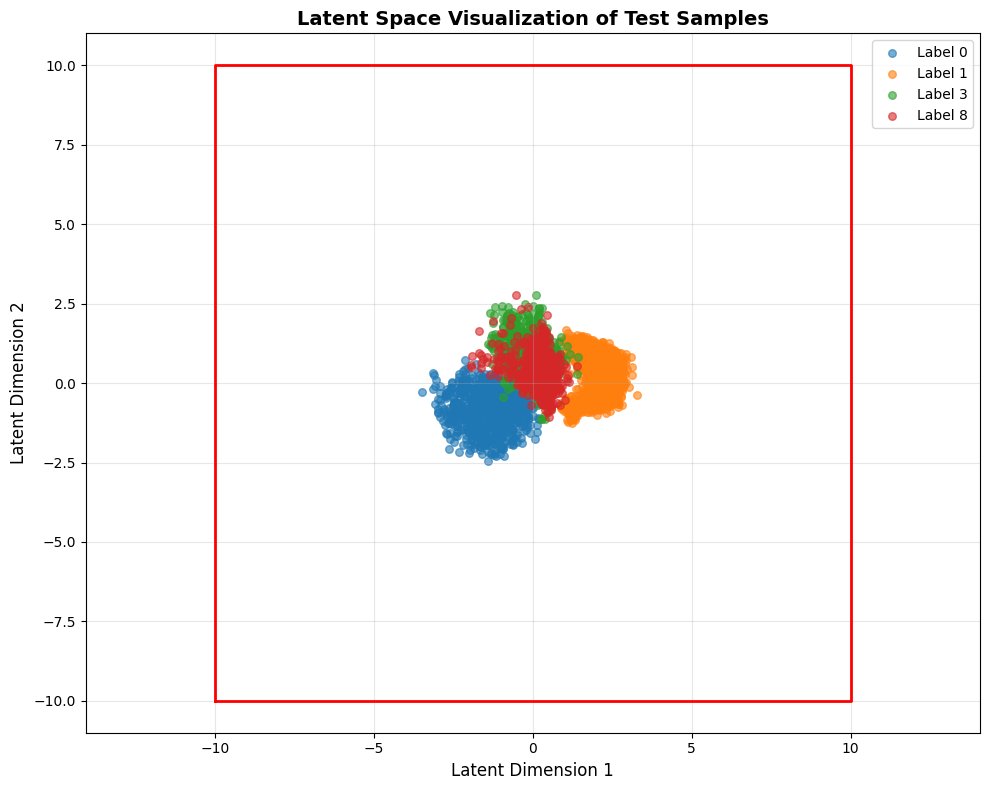


=== Latent Space Statistics ===

Label 0:
  Count: 980
  Dim 1 - Mean: -1.2432, Std: 0.7050
  Dim 2 - Mean: -0.7381, Std: 0.6001

Label 1:
  Count: 1135
  Dim 1 - Mean: 1.9190, Std: 0.4691
  Dim 2 - Mean: 0.2811, Std: 0.6861

Label 3:
  Count: 1010
  Dim 1 - Mean: -0.2108, Std: 0.4240
  Dim 2 - Mean: 0.8337, Std: 0.5215

Label 8:
  Count: 974
  Dim 1 - Mean: 0.2000, Std: 0.4109
  Dim 2 - Mean: 0.2990, Std: 0.4856


In [5]:
# Latent space 시각화
visualize_latent_space(
    autoencoder,
    mnist,
    cfg.data.target_labels,
    use_train=False
)

# 3. Latent Space에서 이미지 생성
특정 latent 좌표에서 이미지를 생성합니다.

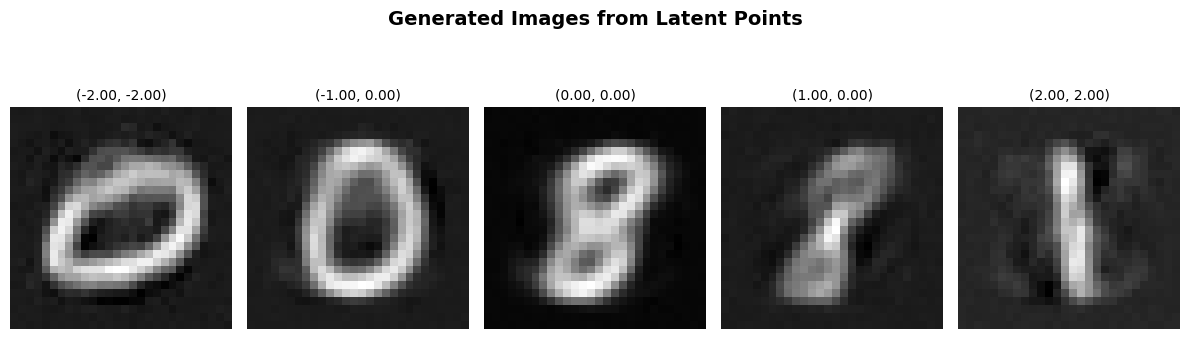

array([[[-7.99692236e-04, -6.19592890e-03, -2.47575529e-03, ...,
         -1.56713314e-02,  5.77699766e-03,  1.00001059e-02],
        [ 2.65062973e-03,  4.24638949e-03,  5.14345989e-03, ...,
         -4.48909821e-03, -5.59327751e-03,  5.02287038e-03],
        [ 1.56513192e-02,  5.76259941e-03,  5.59132919e-03, ...,
         -3.63885378e-03,  3.17993015e-03,  1.39170140e-03],
        ...,
        [-3.51797417e-03,  1.27545185e-02,  5.34416921e-03, ...,
          1.86017528e-03,  2.34545730e-02,  7.09202886e-03],
        [ 6.14895672e-03, -5.25177270e-03,  7.78497290e-03, ...,
          6.41334802e-03, -1.24938712e-02,  1.80981159e-02],
        [ 7.22019002e-04,  8.49210843e-03, -8.27634893e-03, ...,
          2.51563359e-03,  3.97645310e-03, -1.64916962e-02]],

       [[-4.06952482e-03,  7.72587955e-05, -1.83949061e-03, ...,
         -5.98500576e-03, -2.68072262e-03,  1.90934911e-03],
        [ 1.34930387e-03,  1.91105250e-03, -1.70252100e-03, ...,
          3.54753016e-03, -6.09618425e

In [6]:
import torch

# 특정 latent 좌표에서 이미지 생성
latent_points = torch.tensor([
    [-2.0, -2.0],
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 0.0],
    [2.0, 2.0],
])

generate_from_latent(autoencoder, latent_points)

# 4. Latent Space Grid 시각화
Latent space를 그리드로 나누어 각 위치에서 생성되는 이미지를 시각화합니다.

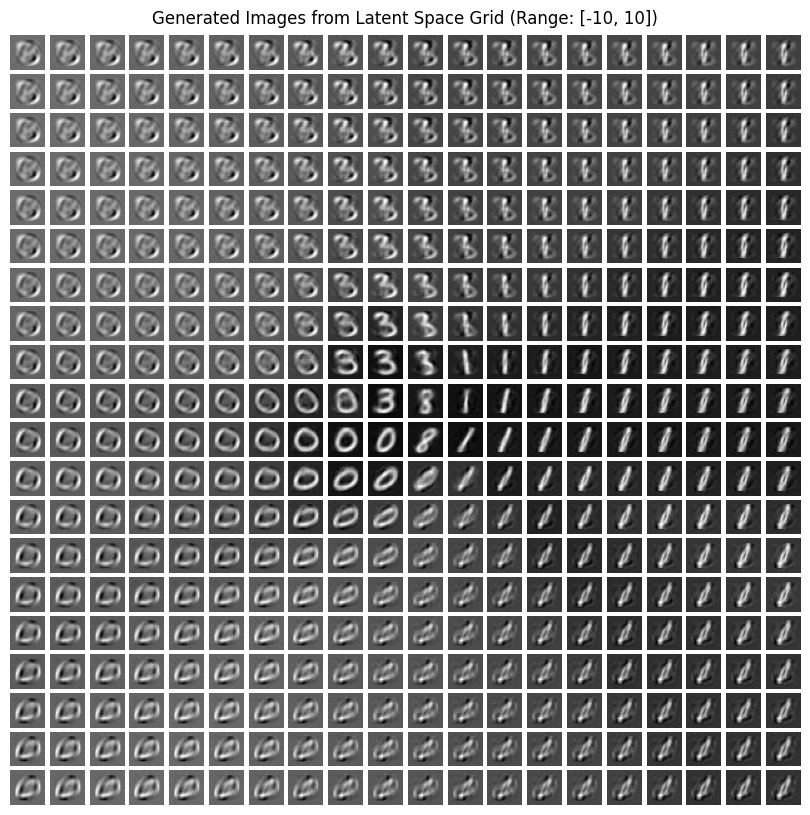

15:33:10|INFO|visualize_autoencoder.py:245| Generated 400 images from latent space grid


In [7]:
# Latent space를 15x15 그리드로 시각화
generate_latent_grid(autoencoder, n_samples=20, latent_range=10)